In [1]:
import cufflinks
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'svg'

C:\Users\mtay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


## Refresh Data

In [2]:
import yfinance
tickers = ['BZ=F','CL=F','RB=F','NG=F','HO=F','HE=F']
data = yfinance.download(tickers, period='10y', interval='1d')
close_price = data['Close']
df = pd.DataFrame(close_price)
df.dropna(inplace=True)
df = df.drop('20-04-2020')
df.to_csv('yFinance.csv')

[*********************100%***********************]  6 of 6 completed


In [3]:
df.head()

,BZ=F,CL=F,HE=F,HO=F,NG=F,RB=F
Date,,,,,,
2012-05-07,113.160004,97.940002,80.050003,2.9814,2.336,2.9741
2012-05-08,112.730003,97.010002,80.250000,2.9901,2.393,2.9944
2012-05-09,113.199997,96.809998,80.074997,2.9991,2.465,3.0241
2012-05-10,112.730003,97.080002,79.800003,2.9834,2.487,3.0102
2012-05-11,112.260002,96.129997,79.525002,2.9636,2.509,3.0008


## OOP Method: FinancialData for data preparation

In [4]:
class FinancialData:
    url = "yFinance.csv"
    def __init__(self, symbol):
        self.symbol = symbol
        self.retrieve_data()
        self.prepare_data()
    def retrieve_data(self):
        self.raw = pd.read_csv(self.url, index_col=0)
    def prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data/self.data.shift(1))
    def plot_data(self, cols, lookback_period):
        self.lookback_period = lookback_period
        self.data[cols].iloc[self.lookback_period:].plot(title=self.symbol, secondary_y='p',)

In [5]:
fd = FinancialData('CL=F')
fd.data.head()

,CL=F,r
Date,,
2012-05-07,97.940002,NaN
2012-05-08,97.010002,-0.009541
2012-05-09,96.809998,-0.002064
2012-05-10,97.080002,0.002785
2012-05-11,96.129997,-0.009834


## OOP Method: SMABacktester for backtesting

In [6]:
class SMABacktester(FinancialData):
    def prepare_statistics(self):
        self.data['SMA1'] = self.data[self.symbol].rolling(self.SMA1).mean()
        self.data['SMA2'] = self.data[self.symbol].rolling(self.SMA2).mean()
        self.data.dropna()
    def backtest_strategy(self, SMA1, SMA2):
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.prepare_statistics()
        self.data['p'] = np.where(self.data['SMA1'] > self.data['SMA2'], 1, -1)
        self.data['s'] = self.data['p'].shift(1) * self.data['r']
        self.data.dropna(inplace=True)
        perf = self.data[['r','s']].sum()
        return perf

## Select the commodity symbol and backtest it

CL=F | SMA1=8 | SMA2=21 | BENCH=26.78 pct | STRAT=334.55 pct
CL=F | SMA1=8 | SMA2=34 | BENCH=18.27 pct | STRAT=225.06 pct
CL=F | SMA1=8 | SMA2=55 | BENCH=17.24 pct | STRAT=79.64 pct
CL=F | SMA1=13 | SMA2=21 | BENCH=24.91 pct | STRAT=303.40 pct
CL=F | SMA1=13 | SMA2=34 | BENCH=16.48 pct | STRAT=159.33 pct
CL=F | SMA1=13 | SMA2=55 | BENCH=13.05 pct | STRAT=100.52 pct
CL=F | SMA1=21 | SMA2=21 | BENCH=15.89 pct | STRAT=-15.89 pct
CL=F | SMA1=21 | SMA2=34 | BENCH=13.53 pct | STRAT=80.13 pct
CL=F | SMA1=21 | SMA2=55 | BENCH=1.13 pct | STRAT=79.86 pct


,CL=F,r,SMA1,SMA2,p,s
Date,,,,,,
2013-10-04,103.839996,0.005117,103.849230,105.592857,-1,-0.005117
2013-10-07,103.029999,-0.007831,103.461538,105.392856,-1,0.007831
2013-10-08,103.489998,0.004455,103.238461,105.160475,-1,-0.004455
2013-10-09,101.610001,-0.018333,103.002307,104.735713,-1,0.018333
2013-10-10,103.010002,0.013684,102.957692,104.425714,-1,-0.013684


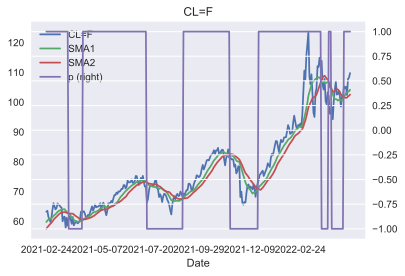

In [7]:
# Select the commodity
sma = SMABacktester('CL=F') 

from itertools import product
sma1 = [8,13,21]
sma2 = [21,34,55]
for SMA1, SMA2 in product(sma1,sma2):
    perf = sma.backtest_strategy(SMA1,SMA2)
    print(f'{sma.symbol} | SMA1={SMA1} | SMA2={SMA2} | BENCH={perf["r"]*100:.2f} pct | STRAT={perf["s"]*100:.2f} pct')

# Select the best MACD combi and plot the returns/strategy
sma.backtest_strategy(13,21) # Select the best pair, and plot the strategy chart
sma.plot_data([sma.symbol,'SMA1','SMA2','p'], lookback_period = -300)
sma.data.head()

## Select the best MACD combi and plot the returns/strategy

In [8]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

In [9]:
df2 = sma.data
df2.head()

,CL=F,r,SMA1,SMA2,p,s
Date,,,,,,
2013-10-04,103.839996,0.005117,103.849230,105.592857,-1,-0.005117
2013-10-07,103.029999,-0.007831,103.461538,105.392856,-1,0.007831
2013-10-08,103.489998,0.004455,103.238461,105.160475,-1,-0.004455
2013-10-09,101.610001,-0.018333,103.002307,104.735713,-1,0.018333
2013-10-10,103.010002,0.013684,102.957692,104.425714,-1,-0.013684


In [10]:
df2['cumulative_returns'] = (df2.s+1).cumprod()
"The total strategy returns are %.2f pct" % ((df2['cumulative_returns'].iloc[-1]-1)*100)

'The total strategy returns are 822.65 pct'

In [11]:
df2.tail()

,CL=F,r,SMA1,SMA2,p,s,cumulative_returns
Date,,,,,,,
2022-05-02,105.169998,0.004574,103.111538,101.430952,1,0.004574,8.855291
2022-05-03,102.410004,-0.026594,103.250769,101.532381,1,-0.026594,8.619797
2022-05-04,107.809998,0.051386,103.524615,101.939047,1,0.051386,9.062733
2022-05-05,108.260002,0.004165,103.625384,102.176190,1,0.004165,9.100483
2022-05-06,109.769997,0.013851,104.180000,102.548095,1,0.013851,9.226538


In [12]:
s = np.mean(df2['s'])/np.std(df2['s'])*(252**0.5)
'The Sharpe Ratio %.2f' % s

'The Sharpe Ratio 0.76'

The maximum drawdown is -66.68 pct


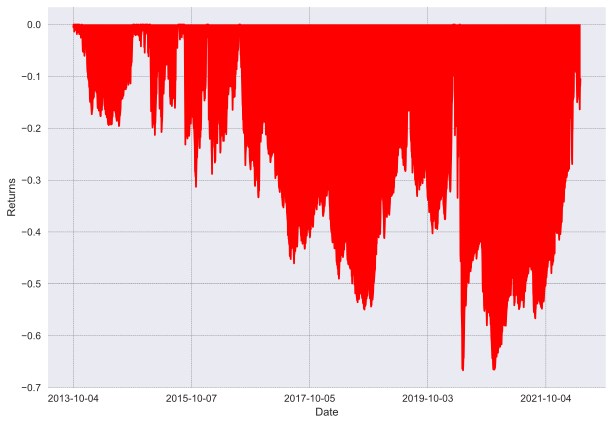

In [13]:
drawdown = calc_drawdown(df2.cumulative_returns)
print("The maximum drawdown is %.2f pct" % (drawdown.min()*100))
plot_drawdown(drawdown)

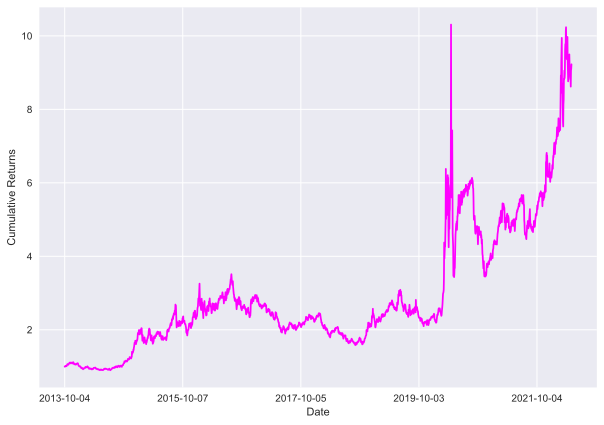

In [14]:
df2.cumulative_returns.plot(label='Returns', figsize=(10,7),color='magenta')  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()